<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Machine Learning**

In [ ]:
pip install -q tensorflow-quantum

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq

import sympy
import numpy as np
import pandas as pd

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

#### **Line Qubits**

* Gate used: Hadamard ([see doc](https://cirq.readthedocs.io/en/stable/generated/cirq.H.html))

* Bristlecone device doesn't support qubit type: cirq.LineQubit(0)

In [18]:
# Step 0: Define Device (optional)
# device = Bristlecone # Unsupported qubit type: cirq.LineQubit(0)

# Step 1: Create Circuit object
circuit = cirq.Circuit() # (device=device)

# Step 2: Define 2 qubits
(q0, q1) = cirq.LineQubit.range(2)

# Step 3: Perform quantum gates on qubits
circuit.append([cirq.H(q0), cirq.CNOT(q0, q1)])
circuit.append([cirq.H(q0), cirq.CNOT(q0, q1)])

# Step 4: Measure quantum bits
circuit.append([cirq.measure(q0), cirq.measure(q1)])

# Step 5: See what circuit has been produced
print(circuit)

0: ───H───@───H───@───M───
          │       │
1: ───────X───────X───M───


In [19]:
# Step 6: Perform simulation of the circuit
sim = cirq.Simulator()
results = sim.run(circuit, repetitions=10)
print(results)

0=1111111111
1=0111101100


#### **Grid Qubits**

* Gate used: CZ - Controlled Z ([see doc](https://cirq.readthedocs.io/en/stable/generated/cirq.CZ.html))

In [23]:
device = cirq.google.Bristlecone

circuit = cirq.Circuit(device=device)

a0, a1 = cirq.GridQubit(5, 5), cirq.GridQubit(5, 6)
b0, b1 = cirq.GridQubit(6, 5), cirq.GridQubit(6, 6)

circuit.append([cirq.CZ(a0, a1), cirq.CZ(b0, b1)])

# Measure quantum bits
circuit.append([cirq.measure(a0, a1), cirq.measure(b0, b1)])

print(circuit)

(5, 5): ───@───M───────
           │   │
(5, 6): ───@───M───────

(6, 5): ───────@───M───
               │   │
(6, 6): ───────@───M───


In [24]:
# Step 5: Perform simulation of the circuit
sim = cirq.Simulator()
results = sim.run(circuit, repetitions=10)
print(results)

(5, 5),(5, 6)=0000000000, 0000000000
(6, 5),(6, 6)=0000000000, 0000000000


#### **See how devices look like**

https://cirq.readthedocs.io/en/latest/docs/google/devices.html

In [15]:
print(cirq.google.Bristlecone)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

In [16]:
print(cirq.google.Sycamore)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

#### **Examples**

https://tensorflow.google.cn/quantum/tutorials/hello_many_worlds?hl=en

https://towardsdatascience.com/quantum-machine-learning-101-1058f24c3487

In [ ]:
def get_data(l):
    data = np.random.randint(0,1,(l,2))
    label = np.ones(l)
    data[0::2,0]=1
    data[1::2,1]=1
    label[0::2] = -1
    p = np.random.permutation(l)
    return data[p], label[p]

x_train, y_train = get_data(5000)
x_test, y_test = get_data(200)
print(pd.DataFrame(np.concatenate((x_train, np.reshape(y_train, (-1,1))), axis=1) , columns=["x1", "x2", "y"]))

       x1   x2    y
0     1.0  0.0 -1.0
1     0.0  1.0  1.0
2     1.0  0.0 -1.0
3     0.0  1.0  1.0
4     1.0  0.0 -1.0
...   ...  ...  ...
4995  1.0  0.0 -1.0
4996  0.0  1.0  1.0
4997  1.0  0.0 -1.0
4998  0.0  1.0  1.0
4999  1.0  0.0 -1.0

[5000 rows x 3 columns]


In [ ]:
def convert_to_circuit(x):
    qubits = cirq.GridQubit.rect(1, 2)
    circuit = cirq.Circuit()
    for i, val in enumerate(x):
        if val:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [ ]:
x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

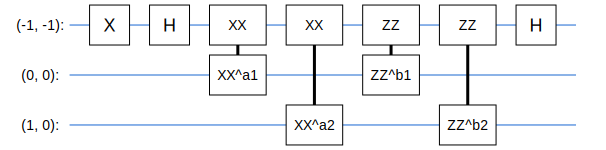

In [ ]:
input_qubits = cirq.GridQubit.rect(2, 1)  # 2x1 grid.
readout = cirq.GridQubit(-1, -1)   # a qubit at [-1,-1]
model_circuit = cirq.Circuit()

model_circuit.append(cirq.X(readout))
model_circuit.append(cirq.H(readout))

alpha1 = sympy.Symbol('a1')
model_circuit.append(cirq.XX(input_qubits[0], readout)**alpha1)

alpha2 = sympy.Symbol('a2')
model_circuit.append(cirq.XX(input_qubits[1], readout)**alpha2)

beta1 = sympy.Symbol('b1')
model_circuit.append(cirq.ZZ(input_qubits[0], readout)**beta1)

beta2 = sympy.Symbol('b2')
model_circuit.append(cirq.ZZ(input_qubits[1], readout)**beta2)

model_circuit.append(cirq.H(readout))
model_readout = cirq.Z(readout)
SVGCircuit(model_circuit)

In [ ]:
# Build the model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # PQC layer returns the expected val of the readout gate @[-1,1]
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"])

https://tensorflow.google.cn/api_docs/python/tf/keras/losses/Hinge

https://www.tensorflow.org/guide/keras/train_and_evaluate

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Plot Losses Keras TF (simple)
!pip install livelossplot --quiet
from livelossplot import PlotLossesKerasTF

callbacks = [PlotLossesKerasTF()]

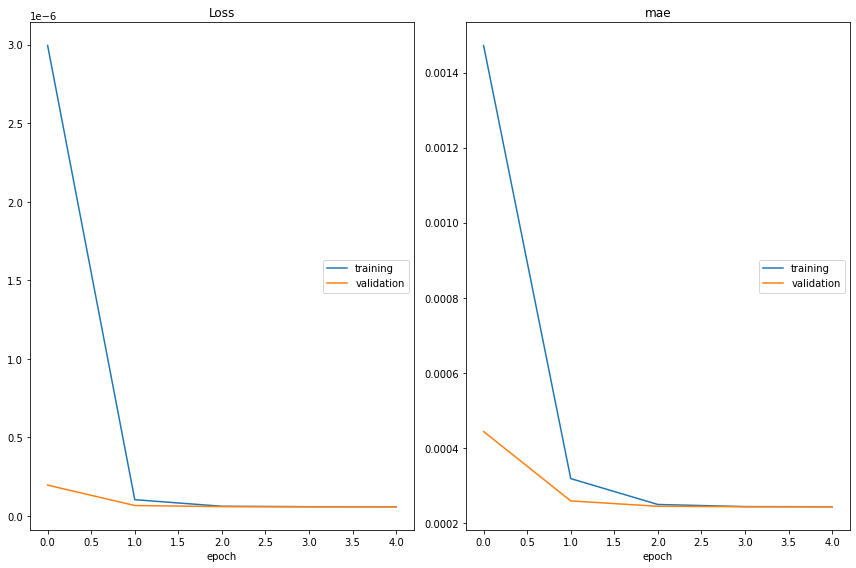

Loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
mae
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
7/7 [==============================] - 0s 6ms/step - loss: 5.9036e-08 - mae: 2.4295e-04


In [ ]:
model_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=200,
      epochs=5,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test),
      callbacks=callbacks)

results = model.evaluate(x_test_tfcirc, y_test)

In [ ]:
print(list(zip(model.predict(x_test_tfcirc).ravel()[:10], y_test[:10])))

[(-0.99654704, -1.0), (0.996547, 1.0), (-0.99654704, -1.0), (0.996547, 1.0), (-0.99654704, -1.0), (0.996547, 1.0), (0.996547, 1.0), (-0.99654704, -1.0), (-0.99654704, -1.0), (-0.99654704, -1.0)]
